In [1]:
import numpy as np
import h5py

from utils.angles import bit2deg, deg2bit
from utils.losses import maad_from_deg

Using TensorFlow backend.


In [2]:
dbpath = '../data/pascal3d.h5'

pascal_db = h5py.File(dbpath, 'r')

train_images = pascal_db['train/aeroplane/images']
train_azimuth = pascal_db['train/aeroplane/labels'][:, 1]
train_azimuth_bit = deg2bit(train_azimuth)
train_elevation = pascal_db['train/aeroplane/labels'][:, 2]
train_elevation_bit = deg2bit(train_elevation)
train_tilt = pascal_db['train/aeroplane/labels'][:, 3]
train_tilt_bit = deg2bit(train_tilt)
train_angles = {'azimuth': train_azimuth_bit,
                'elevation': train_elevation_bit,
                'tilt': train_tilt_bit}
# train_angles = pascal_db['train/aeroplane/labels'][:, 1:]
# train_angles_bit = deg2bit(train_angles).swapaxes(0, 1).reshape([-1, 6])

val_images = pascal_db['validation/aeroplane/images']
val_azimuth = pascal_db['validation/aeroplane/labels'][:, 1]
val_azimuth_bit = deg2bit(val_azimuth)
val_elevation = pascal_db['validation/aeroplane/labels'][:, 2]
val_elevation_bit = deg2bit(val_elevation)
val_tilt = pascal_db['validation/aeroplane/labels'][:, 3]
val_tilt_bit = deg2bit(val_tilt)
val_angles = {'azimuth': val_azimuth_bit,
              'elevation': val_elevation_bit,
              'tilt': val_tilt_bit}

# val_angles = pascal_db['validation/aeroplane/labels'][:, 1:]
# val_angles_bit = deg2bit(val_angles).swapaxes(0, 1).reshape([-1, 6])

n_train_images, image_height, image_width, n_channels = train_images.shape

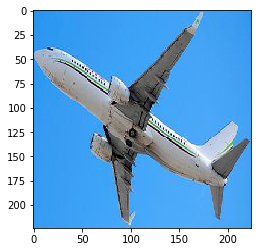

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(np.asarray(train_images[0], dtype='uint8'))

In [3]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam

from models import vgg

from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


def biternion_vgg(image_height, image_width, n_channels, 
                   name='biternion_vgg', loss_type='cosine'):

    X_input = Input(shape=[image_height, image_width, n_channels], name='input_image')

    vgg_img = vgg.vgg_model(final_layer=False,
                            image_height=image_height,
                            image_width=image_width,
                            n_channels=n_channels)(X_input)

    theta_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean')(Dense(2, activation='linear')(vgg_img))
    theta_kappa =  Lambda(lambda x: K.abs(x), name='theta_kappa')(Dense(1, activation='linear')(vgg_img))
    
    y_pred = concatenate([theta_mean, theta_kappa])
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        if loss_type=='cosine':
            theta_loss = cosine_loss_tf(theta_target, theta_mean)
            loss = theta_loss
            
        elif loss_type=='vm_likelihood':
            theta_loss = von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
            loss = -theta_loss
             
        return loss
    
    model = Model(X_input, y_pred, name=name)
    
    opt = Adam(lr=1.0e-4)
    model.compile(optimizer=opt, loss=_loss)
    
    return model

def evaluate_model(model, images, y_target, data_part, loss_type='cosine'):
    
    y_pred = model.predict(images, batch_size=32, verbose=1)
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]
        
        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    theta_target = _unpack_target(y_target)
    theta_mean, theta_kappa = _unpack_preds(y_pred) 
    
    preds_theta = bit2deg(theta_mean)
    gt_theta = bit2deg(theta_target)
    theta_maad = np.mean(maad_from_deg(gt_theta, preds_theta))
    print("MAAD (%s): %f" %(data_part, theta_maad))
    theta_ll = np.mean(von_mises_log_likelihood_np(theta_target, theta_mean, theta_kappa))
    print("Log-likelihood (%s): %f" %(data_part, theta_ll))
    
    return

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(angle='azimuth', loss='cosine'):
    
    print("defining the model..")
    
    model = biternion_vgg(image_height, image_width, n_channels, loss_type=loss)
    
    ckpt_path = '../logs/%s_model_%s.ckpt' %(angle, loss)

    early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    print("training on %s angle, loss type: %s" % (angle.upper(), loss.upper()) )
    model.fit(train_images, train_angles[angle],
              validation_split=0.1,
              epochs=10,
              batch_size=8,
              callbacks=[early_stop_cb, model_ckpt])

    model.load_weights(ckpt_path)
    print("training finished. Checkpoint path : %s" % ckpt_path)

    print("evaluating %s model.." % angle.upper())
    evaluate_model(model, train_images, train_angles[angle], 'train' )
    evaluate_model(model, val_images, val_angles[angle], 'validation')
    
    K.clear_session()
    
    return 

In [23]:
train_model(angle='azimuth', loss='vm_likelihood')

defining the model..
training on AZIMUTH angle, loss type: VM_LIKELIHOOD
Train on 768 samples, validate on 86 samples
Epoch 1/10
768/768 [==============================] - 26s - loss: 5.3196 - val_loss: 2.3384
Epoch 2/10
768/768 [==============================] - 24s - loss: 2.2189 - val_loss: 1.8065
Epoch 3/10
768/768 [==============================] - 23s - loss: 1.8066 - val_loss: 1.8102
Epoch 4/10
768/768 [==============================] - 24s - loss: 1.7379 - val_loss: 1.7362
Epoch 5/10
768/768 [==============================] - 24s - loss: 1.6519 - val_loss: 1.7292
Epoch 6/10
768/768 [==============================] - 23s - loss: 1.5619 - val_loss: 1.7443
Epoch 7/10
768/768 [==============================] - 24s - loss: 1.5181 - val_loss: 1.6250
Epoch 8/10
768/768 [==============================] - 24s - loss: 1.3917 - val_loss: 1.6415
Epoch 9/10
768/768 [==============================] - 24s - loss: 1.4121 - val_loss: 1.6190
Epoch 10/10
768/768 [==============================] -

In [10]:
from models.vgg_vmmix import BiternionVGGMixture

K.clear_session()

vggmix = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            learning_rate=1.0e-4)

In [ ]:
ckpt_path = '../logs/azimuth_model_vggmix.ckpt'

early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

vggmix.model.fit(train_images, 
                 train_angles['azimuth'],
                 validation_split=0.1,
                 epochs=5,
                 batch_size=8,
                 callbacks=[early_stop_cb, model_ckpt])

Train on 768 samples, validate on 86 samples
Epoch 1/5
104/768 [===>..........................] - ETA: 982s - loss: 6.1924

In [ ]:
from models.cvae import CVAE

cvae_model = CVAE(image_height=image_height,
                  image_width=image_width,
                  n_channels=n_channels,
                  learning_rate=1.0e-4)

ckpt_path = '../logs/azimuth_model_cvae.ckpt'

early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

cvae_model.full_model.fit([train_images, train_angles['azimuth']],
                           train_angles['azimuth'],
                 validation_split=0.1,
                 epochs=10,
                 batch_size=8,
                 callbacks=[early_stop_cb, model_ckpt])

In [41]:
np.savetxt('../logs/aeroplane_pred_view.txt',  aeroplane_preds.astype('int'), fmt='%i') 

In [6]:
#model = biternion_vgg(image_height, image_width, n_channels, loss_type='vm_likelihood')
#model.load_weights('../logs/azimuth_model_vm_likelihood.ckpt')

ckpt_path = '../logs/azimuth_model_vggmix.ckpt'

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import vonmises

def plot_prediction(img, target, pred, kappa=1.0, pdf=None):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(np.asarray(img, dtype='uint8'))
    axs[0].axis('off')
    
    def _plot_vm_pdf(ax):
        x = np.arange(0, 2*np.pi, 0.01)
        xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
        xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_labels)
        if pdf is None:
            pdf = vonmises.pdf(x, loc=pred, kappa=kappa)
        ax.plot(x, pdf) 
        ax.axvline(target, c='red', label='ground truth')
        ax.axvline(pred, c='blue', label='predicted mean')
        ax.set_xlim((0, 2*np.pi))
        ax.set_ylim(0, 1.0)
        ax.legend(loc=1)
        
    _plot_vm_pdf(axs[1])
    
    fig.show()
    
    return

In [39]:
def detection_demo(imgs, target, model, n_to_show=50, random=False):
    
    preds = model.predict(imgs)
    mus = np.deg2rad(bit2deg(preds[:, 0:2]))
    kappas = preds[:, 2:3]
    xvals = np.arange(0, 2*np.pi, 0.01)
    
    
    
    if random:
        frames = np.random.choice(target.shape[0], n_to_show, replace=False)
    else:
        frames = range(0, n_to_show)
   
    for i in frames:
        plot_prediction(imgs[i], target[i], mus[i], kappas[i])
        
    return

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


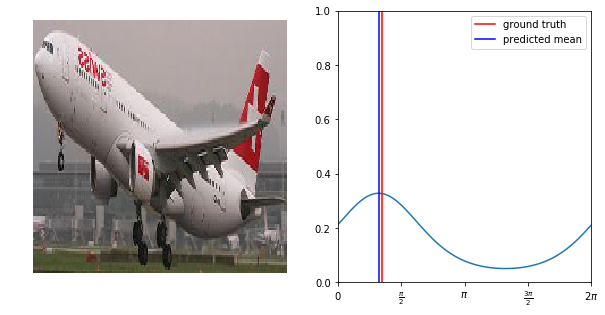

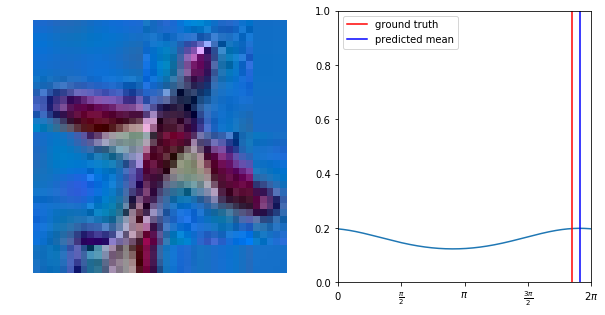

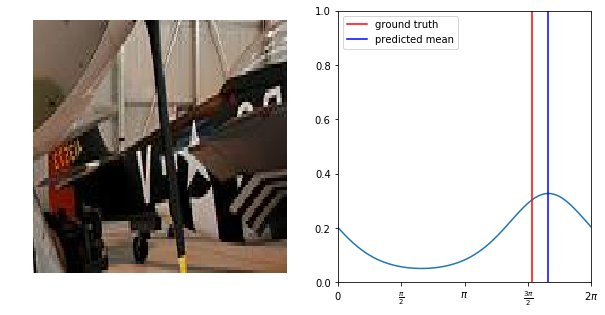

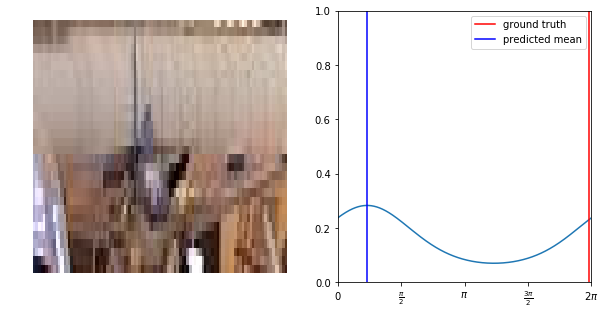

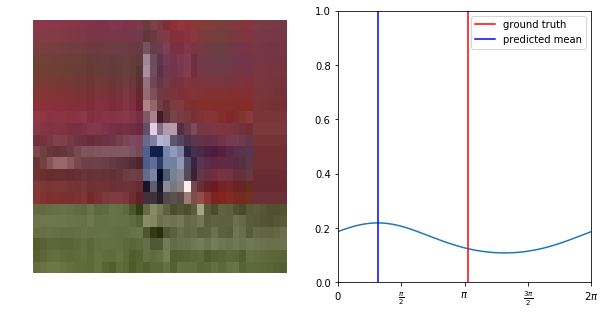

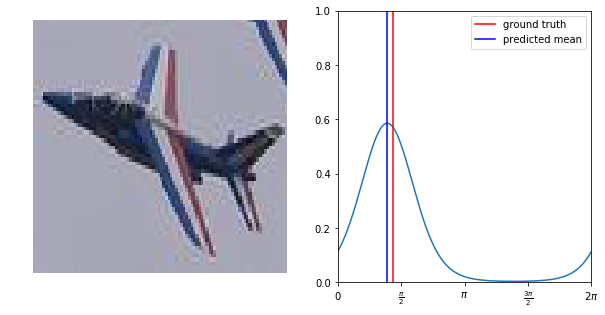

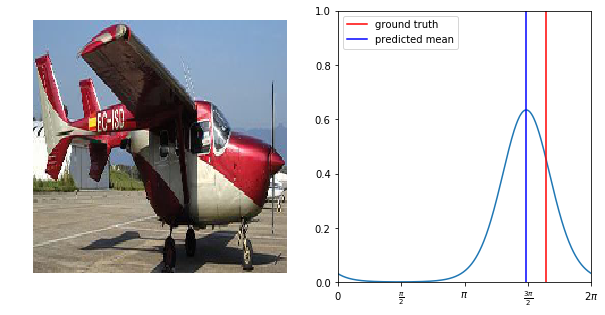

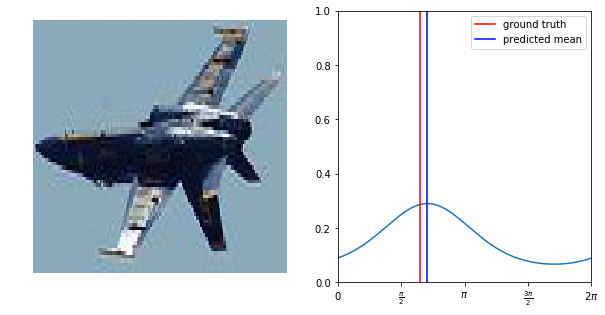

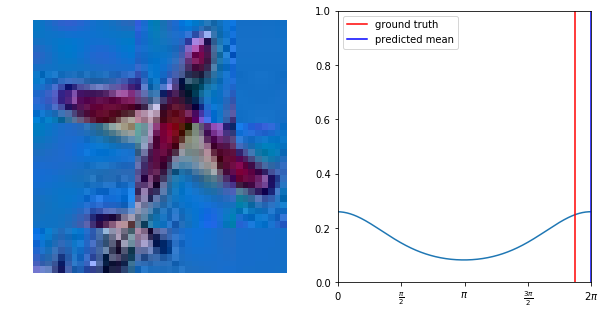

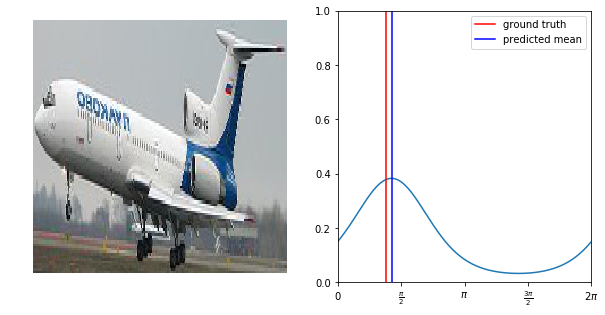

In [44]:
detection_demo(train_images, np.deg2rad(train_azimuth), model, n_to_show=10, random=True)

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


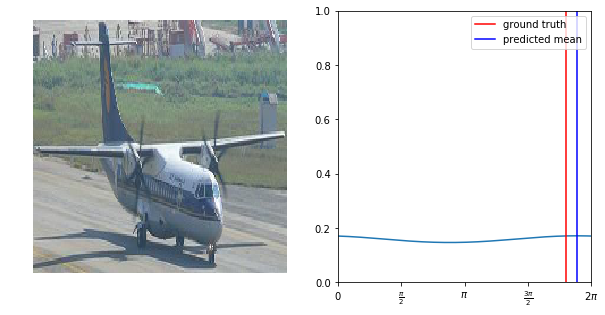

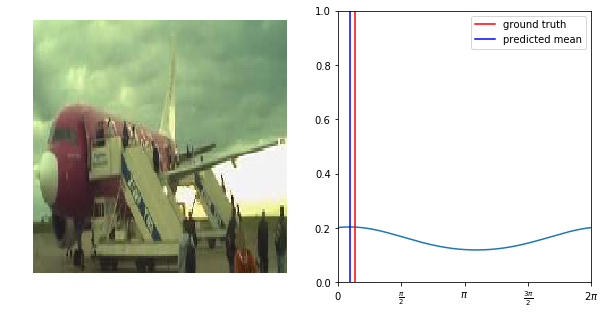

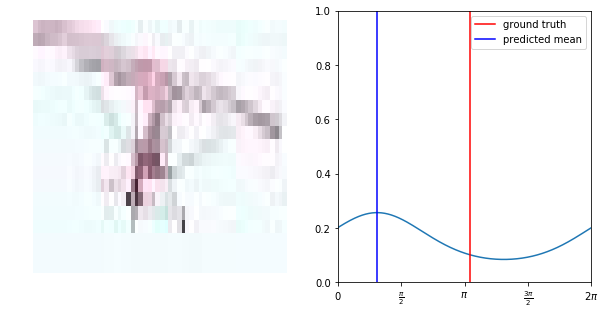

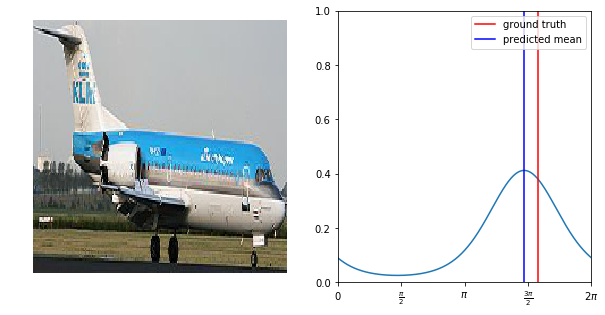

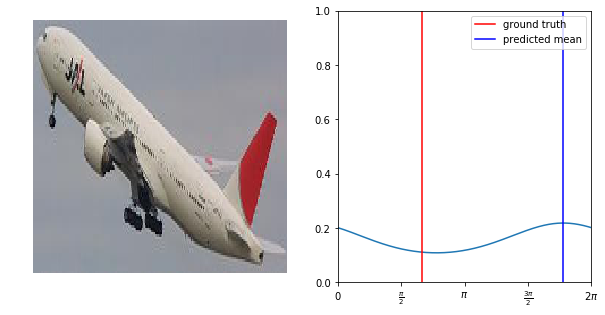

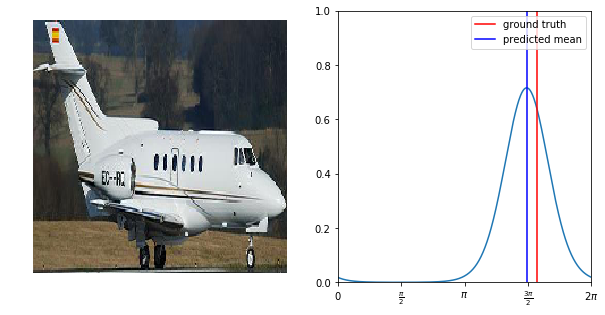

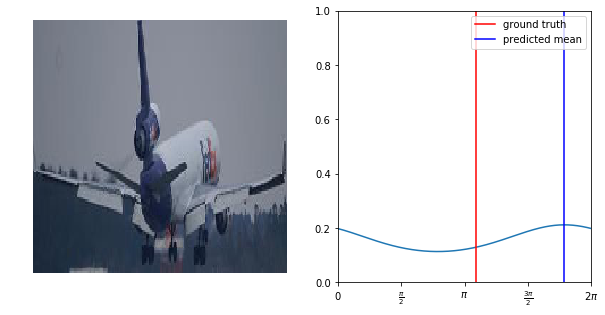

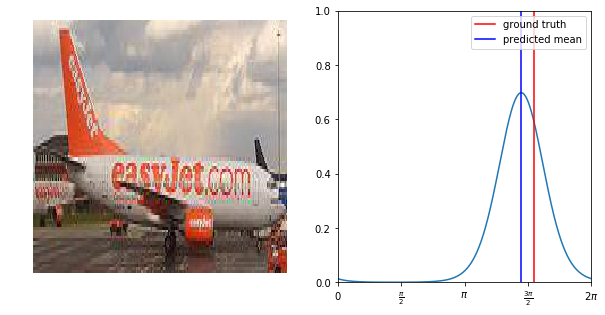

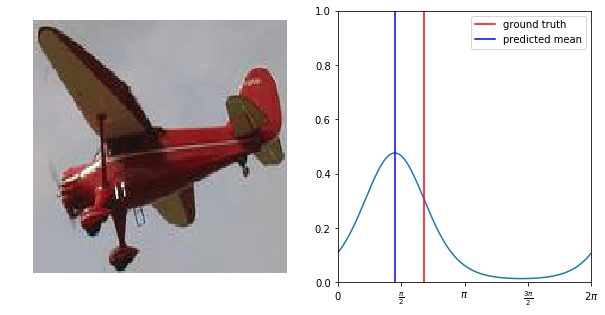

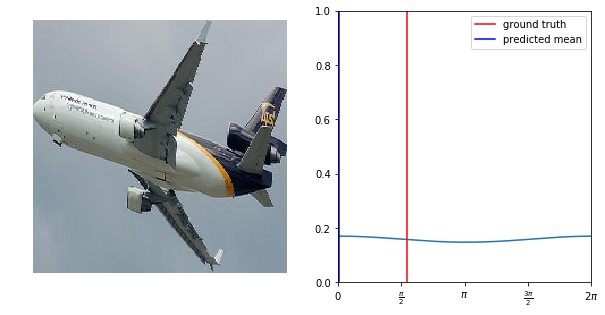

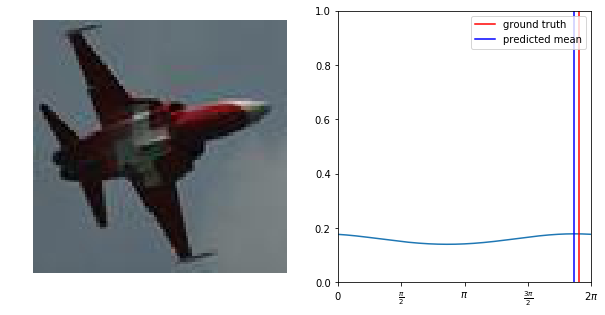

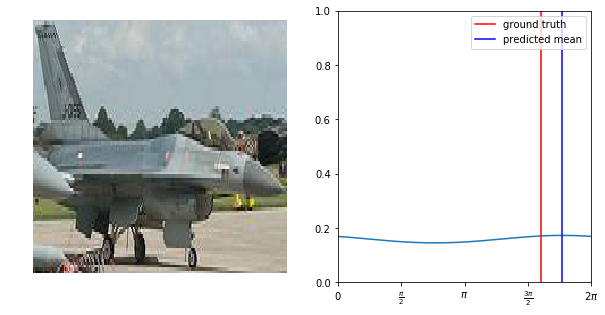

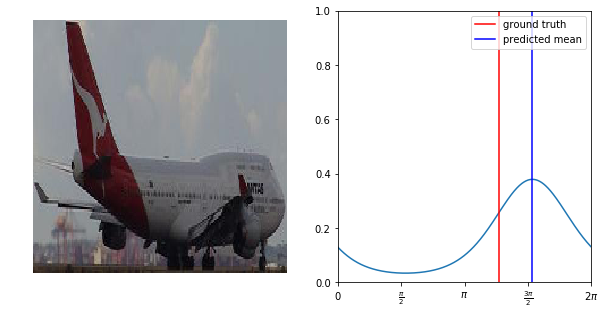

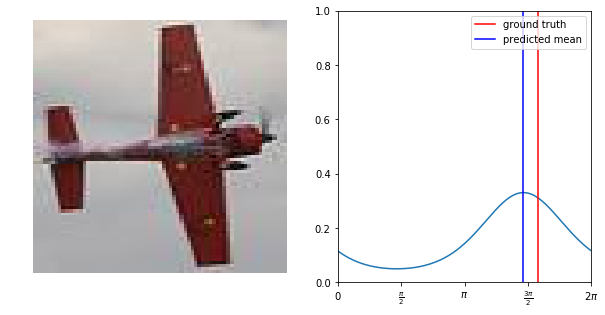

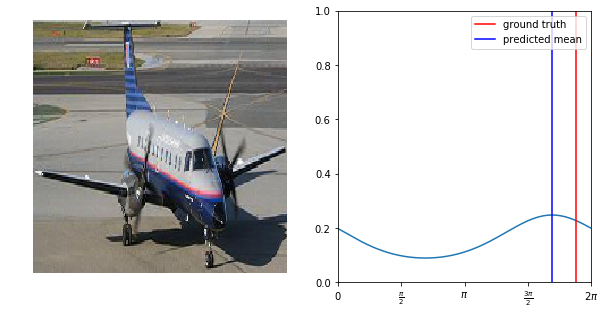

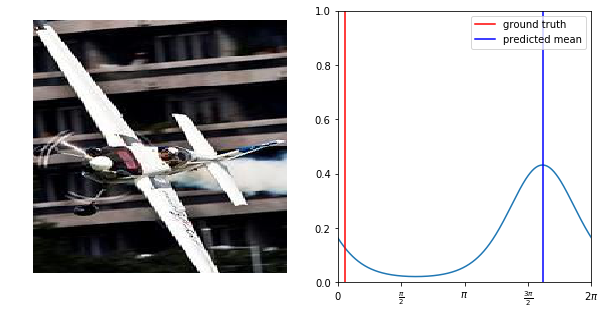

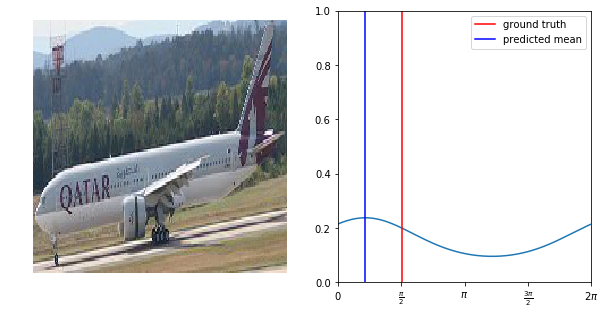

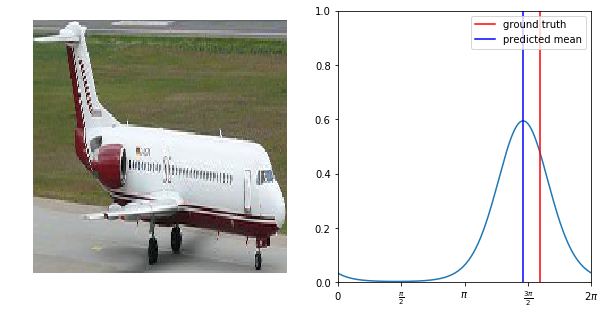

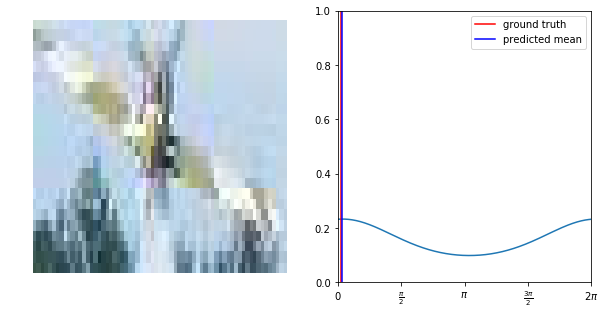

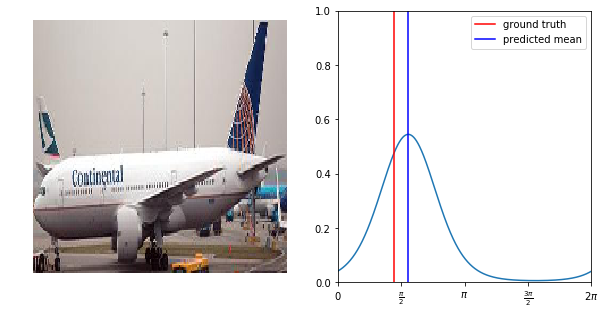

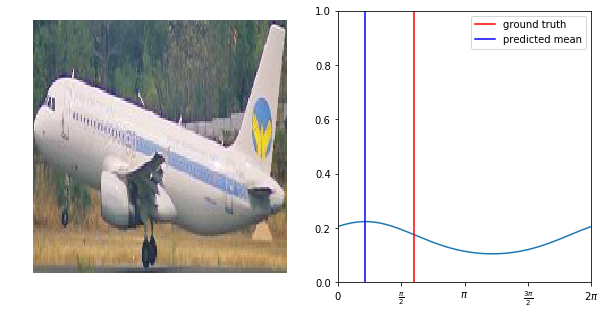

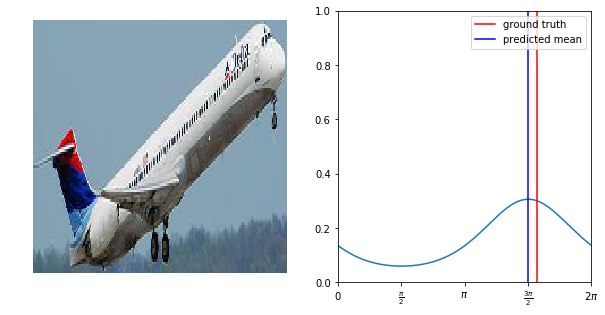

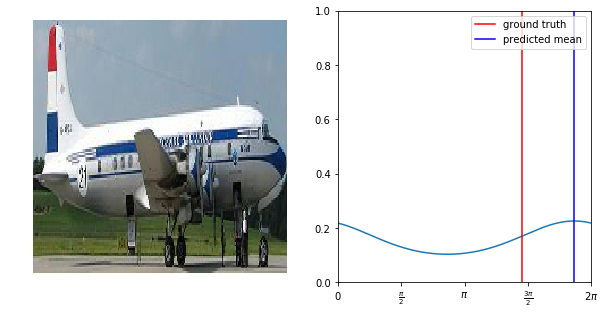

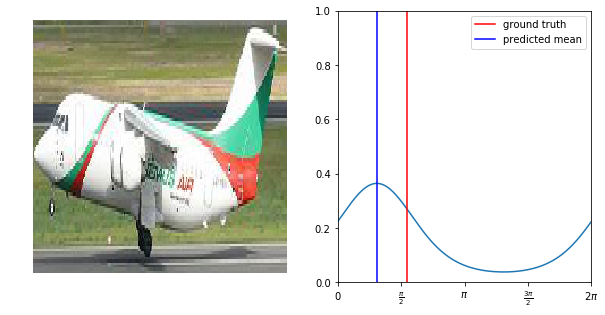

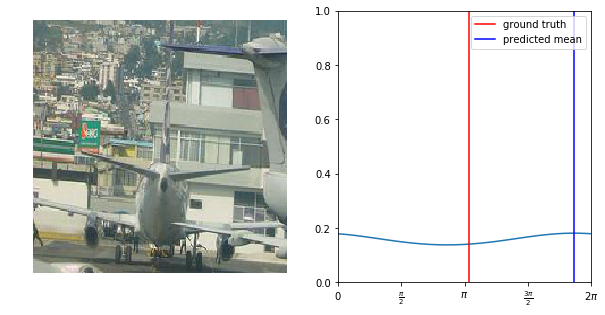

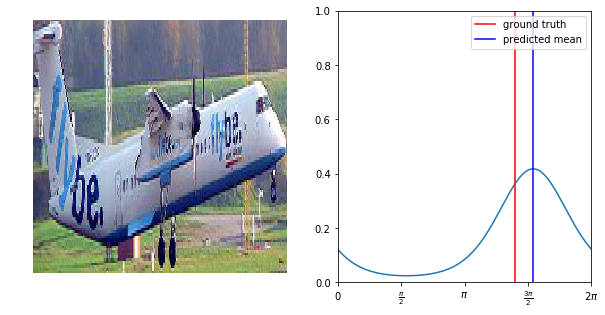

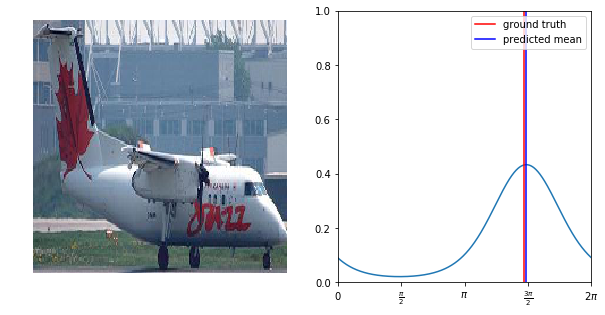

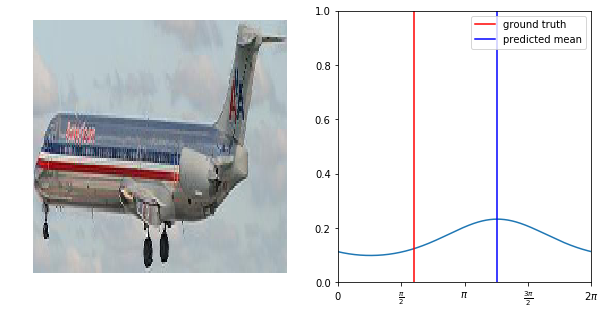

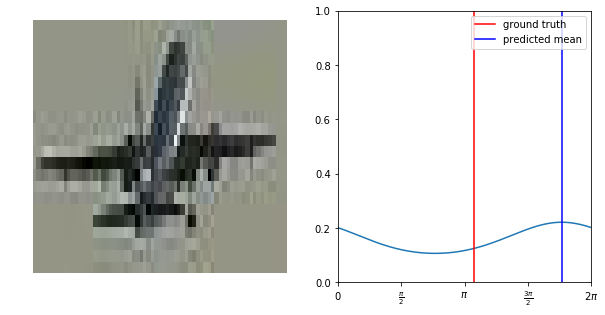

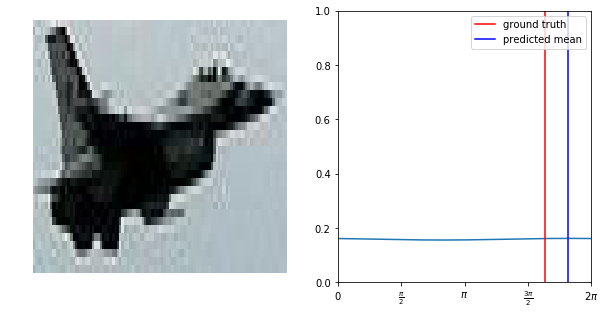

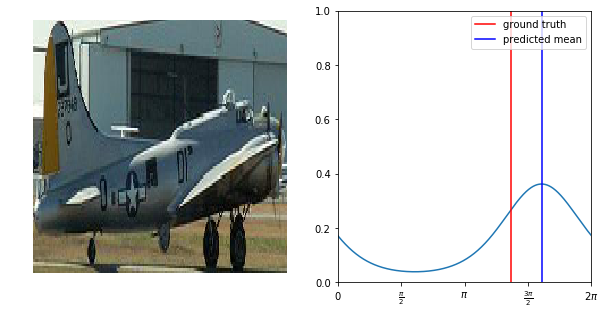

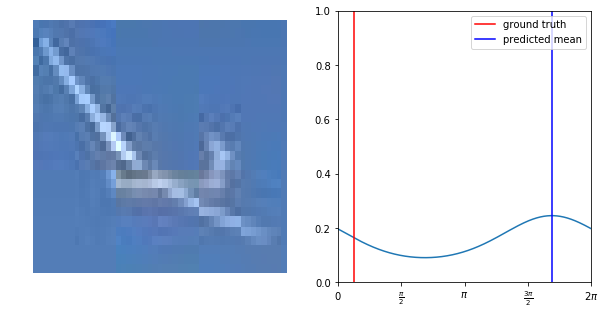

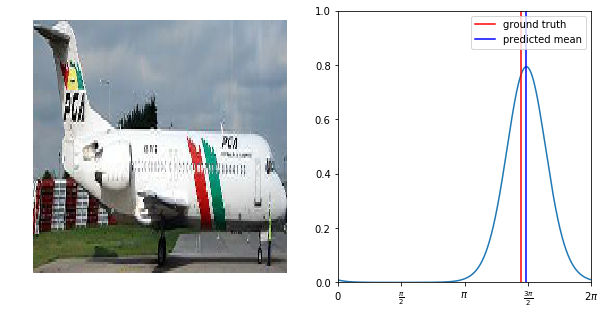

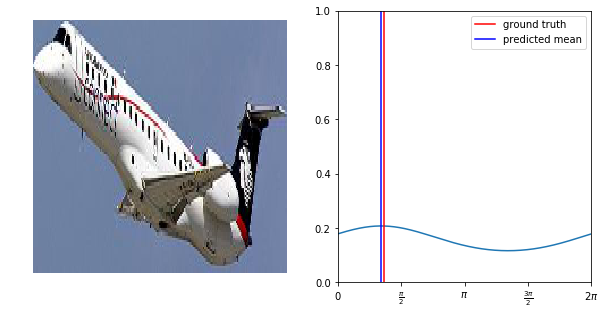

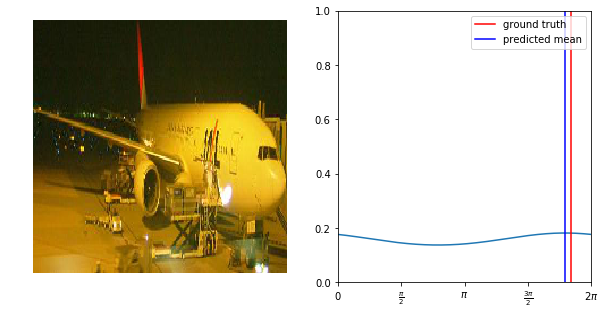

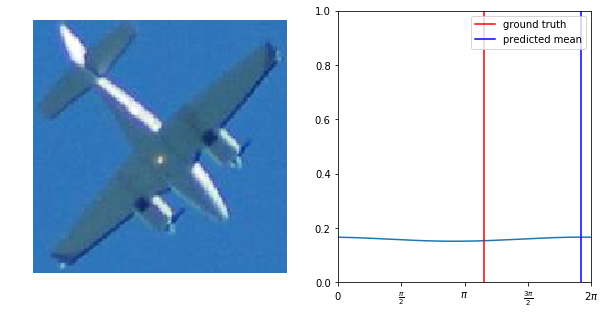

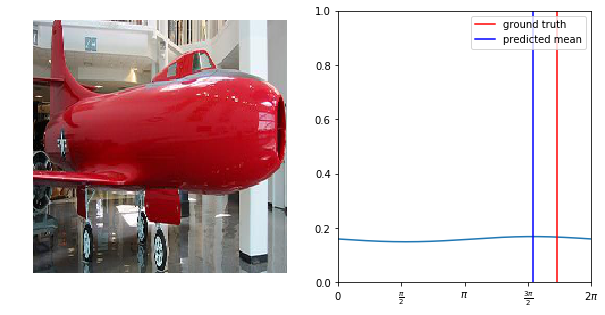

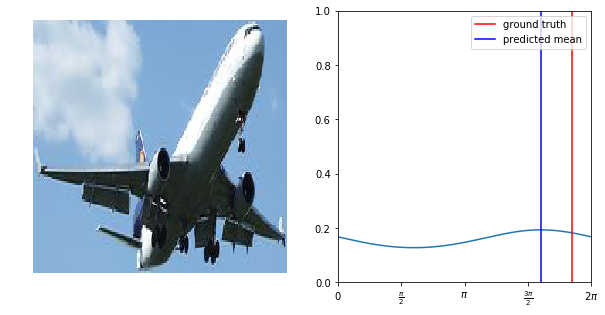

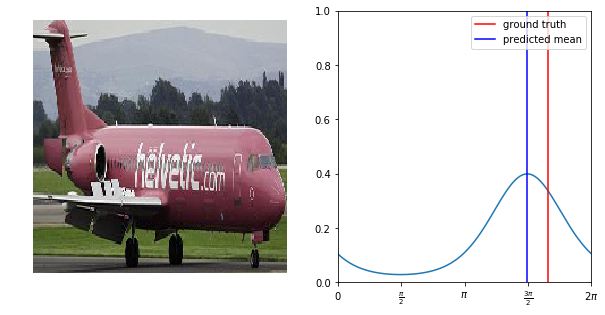

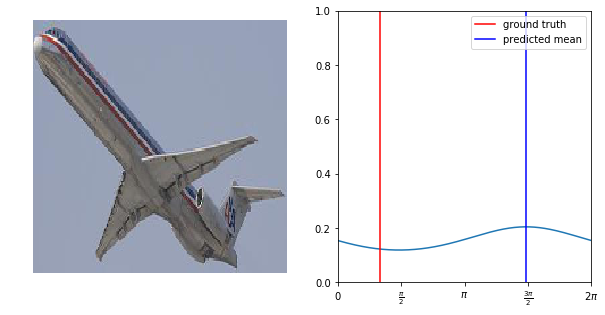

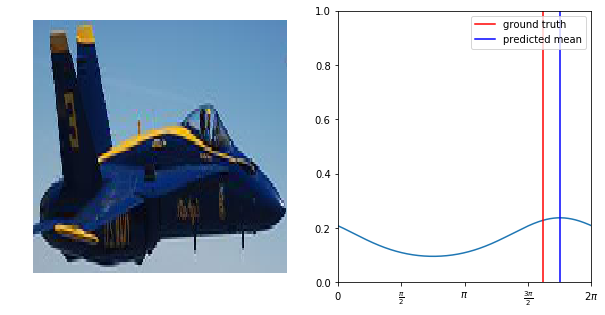

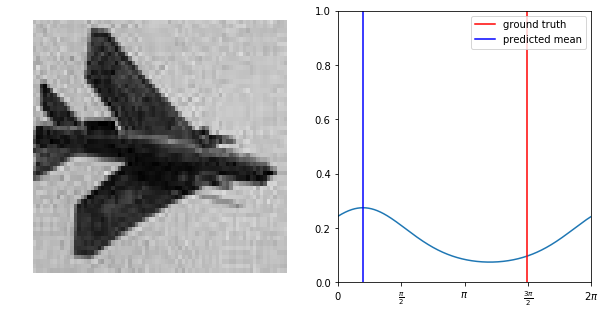

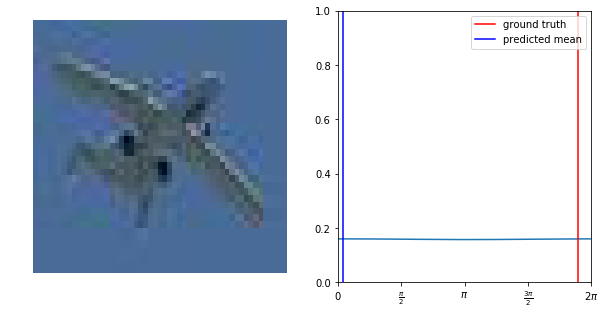

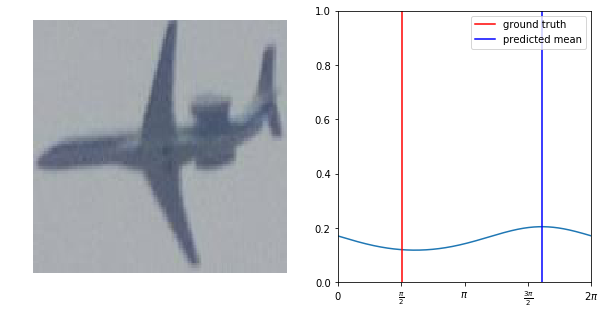

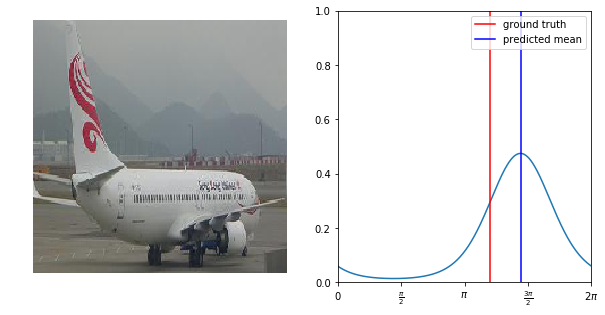

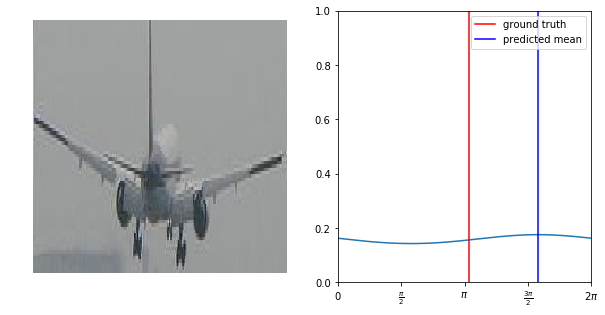

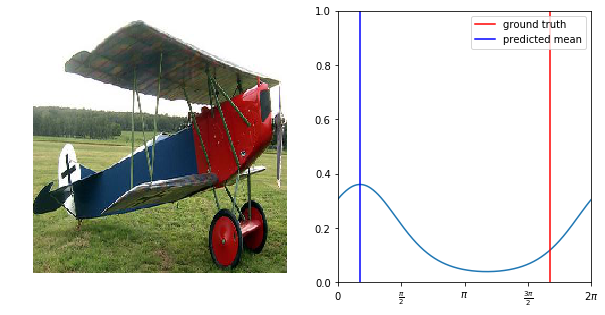

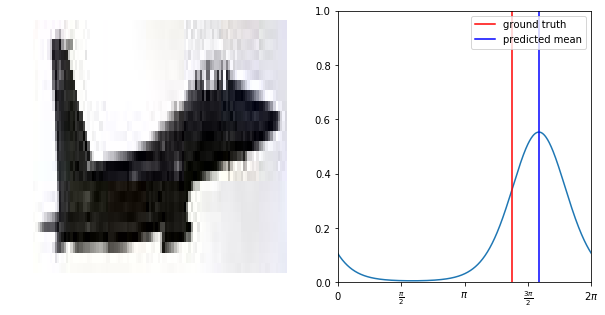

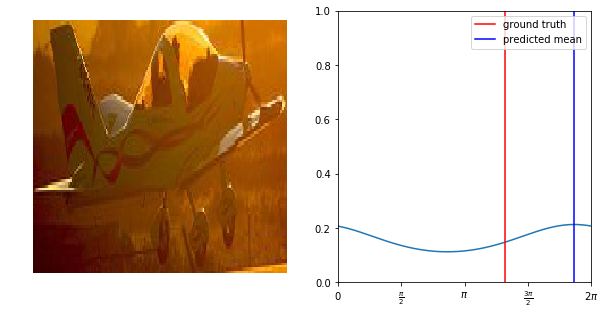

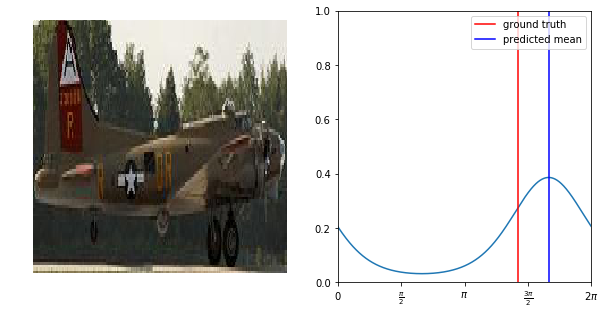

In [48]:
detection_demo(val_images, np.deg2rad(val_azimuth), model, n_to_show=50, random=True)